<a href="https://colab.research.google.com/github/jackychia/AIforCE/blob/master/2912%E7%B5%B1%E4%B8%80_model%E9%9A%8E%E6%AE%B5%E5%9B%9B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!nvidia-smi

Mon Jul 27 14:06:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    57W / 149W |    249MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [23]:
!pip install seaborn
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-dq14msqa
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-dq14msqa
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.04e940eb0938897f9aa70bfa9fc3b3c796537a715_-cp36-none-any.whl size=124955 sha256=c552e922bc455ee86d11d8c975efebe3cc974079bc6456779a017d6fa045771d
  Stored in directory: /tmp/pip-ephem-wheel-cache-mhfnu_rr/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [24]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__) 

2.2.0


In [25]:
#import檔案
dataset_path = keras.utils.get_file("2912", "https://raw.githubusercontent.com/jackychia/AIforCE/master/2912")
dataset_path
#column_names = ['open_pre','open','high','low','close','adj_close','volume']
dataset = pd.read_csv(dataset_path,na_values="0")
dataset

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-07-24,216.5,217.0,214.5,215.5,177.009445,342000.0
1,2015-07-27,214.0,214.0,212.5,213.0,174.955978,847000.0
2,2015-07-28,211.0,216.5,210.0,213.0,174.955978,1173000.0
3,2015-07-29,212.5,213.0,211.0,213.0,174.955978,1078000.0
4,2015-07-30,214.0,225.0,214.0,225.0,184.812653,2803000.0
...,...,...,...,...,...,...,...
1219,2020-07-17,292.0,292.0,289.5,290.0,290.000000,703081.0
1220,2020-07-20,290.0,291.5,290.0,291.0,291.000000,807135.0
1221,2020-07-21,291.0,291.0,289.0,289.0,289.000000,1504961.0
1222,2020-07-22,289.0,291.5,288.5,291.0,291.000000,951691.0


In [ ]:
dataset.isna().sum()

In [ ]:
#drop NaN
dataset = dataset.dropna()
dataset

In [ ]:
#add predict colume to "open_pre"
dataset['Open_pre'] = dataset['Open'].shift(-1)
open_pre = dataset.pop('Open_pre')
dataset

In [ ]:
#normalize
def norm(x):
  A = x.pop('Date')
  x = (x - dataset.min()) / (dataset.max() - dataset.min())
  x = x.transpose()
  x = x.append(A)
  x = x.transpose()
  return x
normed_dataset = norm(dataset)
normed_dataset

In [ ]:
#add "weekday","year","Month" colume from "Date"
normed_dataset['Date'] = pd.to_datetime(normed_dataset['Date'], format='%Y-%m-%d')
normed_dataset['weekday'] = normed_dataset['Date'].apply(lambda x: x.day)
normed_dataset['year'] = normed_dataset['Date'].apply(lambda x: x.year)
normed_dataset['Month'] = normed_dataset['Date'].apply(lambda x: x.month)
normed_dataset

In [ ]:
normed_dataset = normed_dataset.transpose()
normed_dataset = normed_dataset.append(open_pre)
normed_dataset = normed_dataset.transpose()
normed_dataset = normed_dataset.dropna()
normed_dataset

In [32]:
#train & test
test = normed_dataset[-30:]
test = test.reset_index()
train = normed_dataset[(normed_dataset['year']==2019)|((normed_dataset['year']==2020)&(normed_dataset['Month']<=5))|((normed_dataset['year']==2020)&(normed_dataset['Month']==6)&(normed_dataset['weekday']<=20))]
train = train.reset_index()

In [ ]:
test

In [ ]:
train

In [33]:
#Keep the feature u want
train.drop(['Date','year',"index",'Month','weekday','Adj Close'], axis=1, inplace=True) #feature數測試_看數據方差改變情況 開盤 最高 最低 收盤 交易量
test.drop(['Date','year',"index",'Month','weekday','Adj Close'], axis=1, inplace=True)

In [34]:
#Split features from labels
def train_windows(df, ref_day=5, predict_day=1):
    feature, solution = [], []
    for i in range(df.shape[0]-predict_day-ref_day):
        feature.append(np.array(df.iloc[i:i+ref_day,:-1]))
        solution.append(np.array(df.iloc[i+ref_day:i+ref_day+predict_day]["Open_pre"]))
    return np.array(feature), np.array(solution)

In [35]:
feature_train, solution_train = train_windows(train, 5, 1)
feature_test, solution_test = train_windows(test, 5, 1)

In [ ]:
feature_train

In [ ]:
solution_train

In [ ]:
feature_test

In [ ]:
solution_test

In [ ]:
"""
LSTM : 
return_sequences=True 是為了將此層輸出維持2D 傳遞到下一層LSTM 若是為fualt則會平板化!
"""

In [47]:
def lstm_stock_model(shape):
  model = keras.Sequential()
  model.add(layers.LSTM(64, input_shape=(shape[1], shape[2]), return_sequences=True))   #shape[2]第三維向量
  model.add(layers.BatchNormalization())
  model.add(layers.LSTM(256,return_sequences=True))
  model.add(layers.BatchNormalization())
#model.add(layers.TimeDistributed(layers.Dense(1)))   #what is it
  model.add(layers.LSTM(256))
  model.add(layers.Flatten())

  model.add(layers.Dense(5,activation='relu'))
  model.add(layers.Dense(1,activation='relu'))

  Optimizer = keras.optimizers.RMSprop(0.001)
  Optimizer1 = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
  Optimizer2 = keras.optimizers.Adam(learning_rate=0.0001)

  #目前測試L_rate越小越好


  model.compile(loss='mse',optimizer=Optimizer2, metrics=['mae', 'mse'])
  return model

In [48]:
model = lstm_stock_model(feature_train.shape)
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 5, 64)             17920     
_________________________________________________________________
batch_normalization_6 (Batch (None, 5, 64)             256       
_________________________________________________________________
lstm_7 (LSTM)                (None, 5, 256)            328704    
_________________________________________________________________
batch_normalization_7 (Batch (None, 5, 256)            1024      
_________________________________________________________________
lstm_8 (LSTM)                (None, 256)               525312    
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                

In [ ]:
print(feature_train)

In [ ]:
print(type(feature_train))

In [49]:
#類型轉換才能輸入於fit()
from keras import backend as K
feature_train = K.cast_to_floatx(feature_train)
solution_train = K.cast_to_floatx(solution_train)

In [ ]:
print(feature_train)   #轉換後

In [50]:
#fit model
EPOCHS = 1000
Batch_size = 5   #預設5
Batch_size=eval(input('The batch_size (default= 5):') or '5')
EPOCHS=eval(input('Epochs (default 1000):') or '1000')

callback = keras.callbacks.EarlyStopping(monitor="mse", patience=50, verbose=1, mode="auto",restore_best_weights=False) #[tfdocs.modeling.EpochDots()]

history = model.fit(feature_train, solution_train, batch_size=Batch_size, epochs=EPOCHS, validation_split=0.1, verbose=1, callbacks=[callback],shuffle=True)
                    #[callback],shuffle=True)

The batch_size (default= 5):5
Epochs (default 1000):1000
Epoch 1/1000
63/63 [==============================] - 2s 34ms/step - loss: 86105.8125 - mae: 293.2367 - mse: 86105.8125 - val_loss: 90078.8984 - val_mae: 300.1143 - val_mse: 90078.8984
Epoch 2/1000
63/63 [==============================] - 1s 16ms/step - loss: 79483.6875 - mae: 281.7351 - mse: 79483.6875 - val_loss: 90078.8984 - val_mae: 300.1143 - val_mse: 90078.8984
Epoch 3/1000
63/63 [==============================] - 1s 16ms/step - loss: 76986.8906 - mae: 277.2675 - mse: 76986.8906 - val_loss: 90076.2891 - val_mae: 300.1099 - val_mse: 90076.2891
Epoch 4/1000
63/63 [==============================] - 1s 16ms/step - loss: 75255.7031 - mae: 274.1307 - mse: 75255.7031 - val_loss: 90068.8828 - val_mae: 300.0976 - val_mse: 90068.8828
Epoch 5/1000
63/63 [==============================] - 1s 16ms/step - loss: 73674.1641 - mae: 271.2319 - mse: 73674.1641 - val_loss: 90016.1016 - val_mae: 300.0093 - val_mse: 90016.1172
Epoch 6/1000
63/63

In [ ]:
history.history

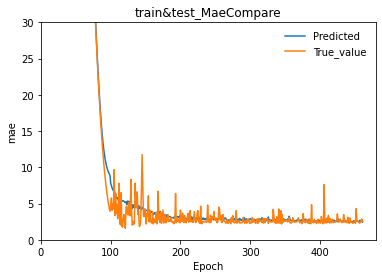

In [53]:
#mae
plt.plot(history.history['mae'],label='Predicted')     #train
plt.plot(history.history['val_mae'],label='True_value')    #test
plt.legend(frameon=False)
plt.xlim([0,480])
plt.ylim([0,30])

plt.title('train&test_MaeCompare')
plt.ylabel('mae')
plt.xlabel('Epoch')
print()

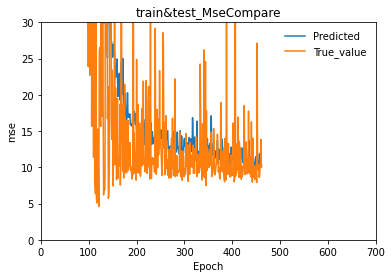

In [54]:
#mse
plt.plot(history.history['mse'],label='Predicted')
plt.plot(history.history['val_mse'],label='True_value')
plt.legend(frameon=False)
plt.xlim([0,700])
plt.ylim([0,30])

plt.title('train&test_MseCompare')
plt.ylabel('mse')
plt.xlabel('Epoch')
print()

In [56]:
feature_test = K.cast_to_floatx(feature_test)
solution_test = K.cast_to_floatx(solution_test)
solution_predict = model.predict(feature_test)

In [57]:
solution_predict

array([[295.09735],
       [296.56802],
       [297.1599 ],
       [297.49765],
       [297.05655],
       [296.3689 ],
       [299.33618],
       [298.87488],
       [293.92917],
       [296.229  ],
       [294.19284],
       [299.79468],
       [296.73407],
       [300.36163],
       [300.1031 ],
       [296.96964],
       [295.65295],
       [289.2782 ],
       [284.24042],
       [283.94742],
       [283.44315],
       [285.9685 ],
       [286.34286],
       [287.0799 ]], dtype=float32)

In [58]:
solution_test

array([[300. ],
       [299.5],
       [298.5],
       [298.5],
       [298.5],
       [300.5],
       [299. ],
       [297. ],
       [297. ],
       [296.5],
       [298.5],
       [297.5],
       [300. ],
       [299. ],
       [296.5],
       [295. ],
       [291.5],
       [288. ],
       [287.5],
       [287.5],
       [292. ],
       [290. ],
       [291. ],
       [289. ]], dtype=float32)

In [59]:
#evaluate loss
loss = model.evaluate(feature_test,solution_test)

1/1 [==============================] - 0s 2ms/step - loss: 11.5787 - mae: 2.8965 - mse: 11.5787


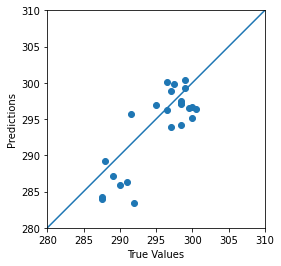

In [60]:
#ture & predict比較圖
a = plt.axes(aspect='equal')
plt.scatter(solution_test, solution_predict)
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [280,310]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


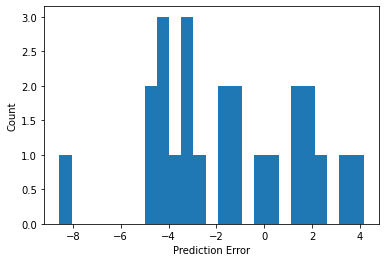

In [61]:
#errort長條圖
error = solution_predict - solution_test
plt.hist(error,bins = 25)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")
